# Predicting Heart Disease with Logistic Regression

In this project, we apply logistic regression techniques to a real-world classification problem using the **Heart Disease Dataset** from the **UCI Machine Learning Repository**.

## Project Overview

The dataset, collected by the Cleveland Clinic Foundation, includes various medical and demographic attributes of patients. The goal is to **predict the presence of heart disease**, a binary classification problem.

This project allows us to:
- Practice the full machine learning pipeline for classification.
- Apply logistic regression in a real-world healthcare context.
- Build a model that could potentially aid in early diagnosis and medical decision-making.

Let's begin by exploring the dataset.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
heart = pd.read_csv("heart_disease.csv")

In [4]:
heart.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


### Dataset Overview

The dataset consists of **303 observations** and **15 columns**, each representing clinical and demographic information about patients. The objective is to **predict the presence of heart disease**, indicated by the binary target variable `present`.

- `age`: Age of the patient (in years)
- `sex`: Biological sex (1 = male, 0 = female)
- `cp`: Chest pain type (categorical)
- `trestbps`: Resting blood pressure (mm Hg)
- `chol`: Serum cholesterol (mg/dl)
- `fbs`: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
- `restecg`: Resting electrocardiographic results (categorical)
- `thalach`: Maximum heart rate achieved
- `exang`: Exercise-induced angina (1 = yes, 0 = no)
- `oldpeak`: ST depression induced by exercise
- `slope`: Slope of the peak exercise ST segment (categorical)
- `ca`: Number of major vessels colored by fluoroscopy (0–3)
- `thal`: Thalassemia (categorical)

#### Target Variable
- `present`: Indicates presence (1) or absence (0) of heart disease.

Note: The `ca` and `thal` columns have object data types and may require preprocessing.


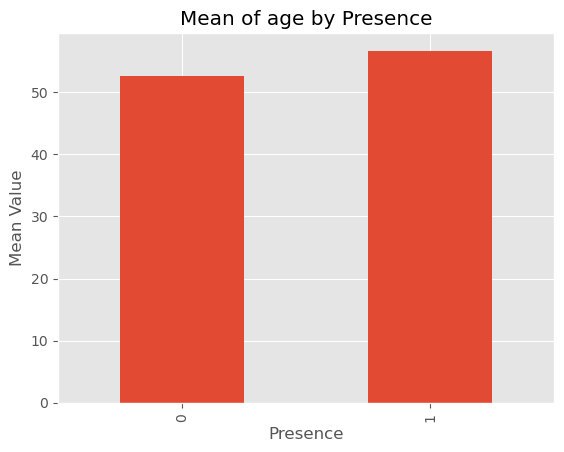

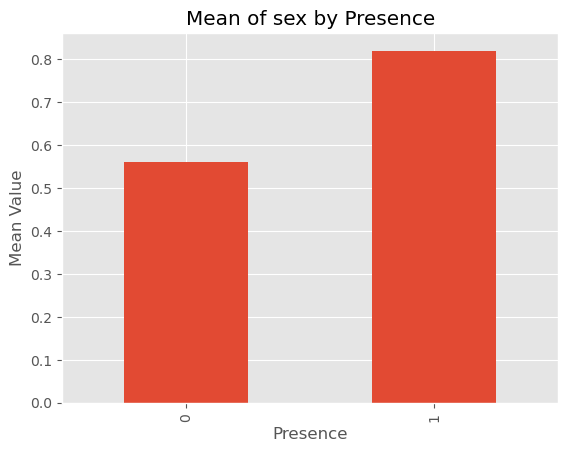

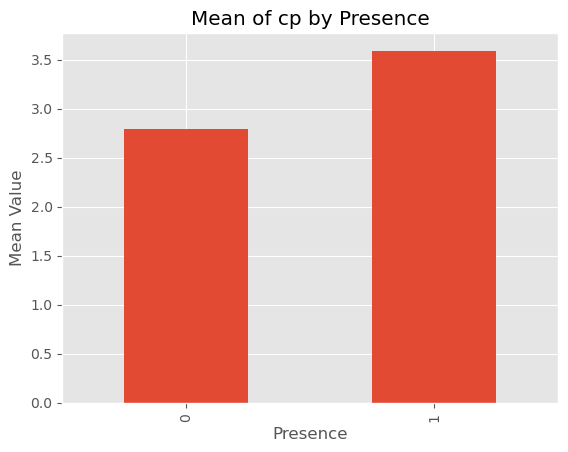

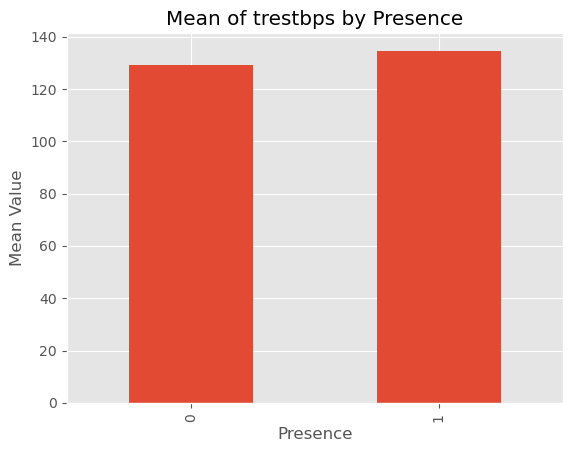

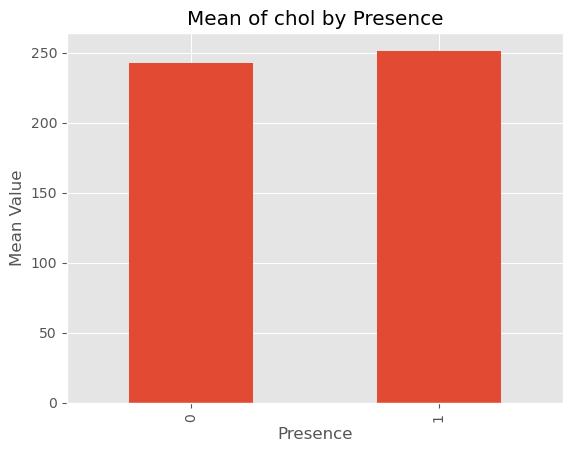

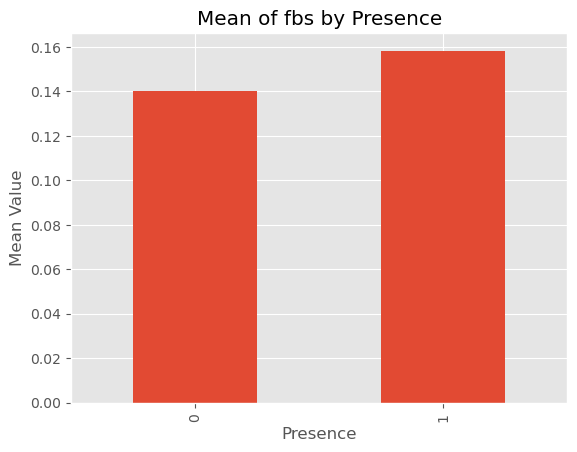

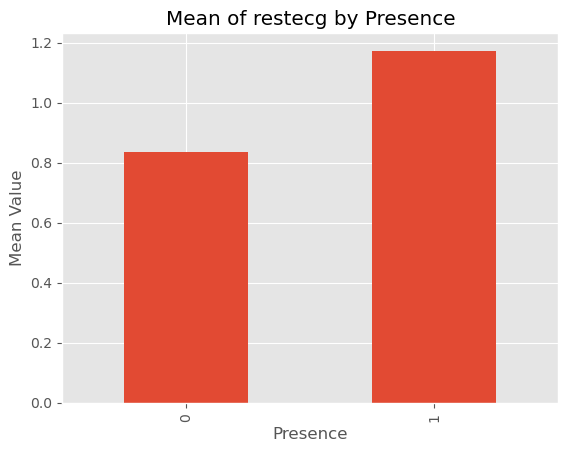

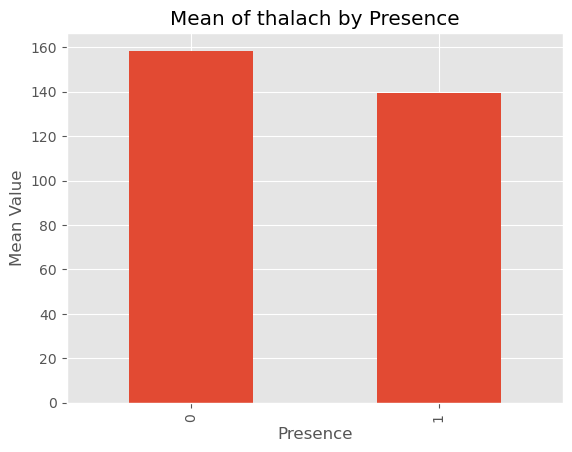

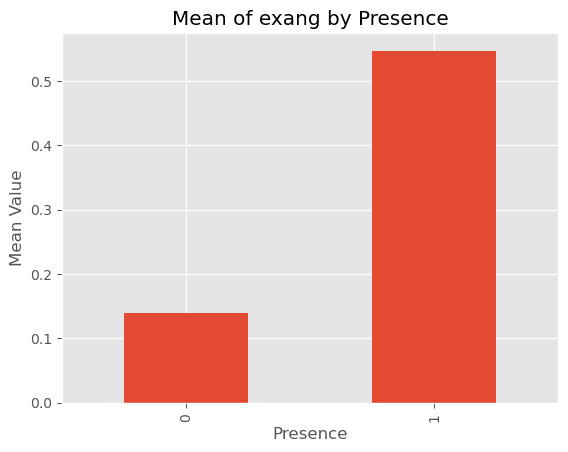

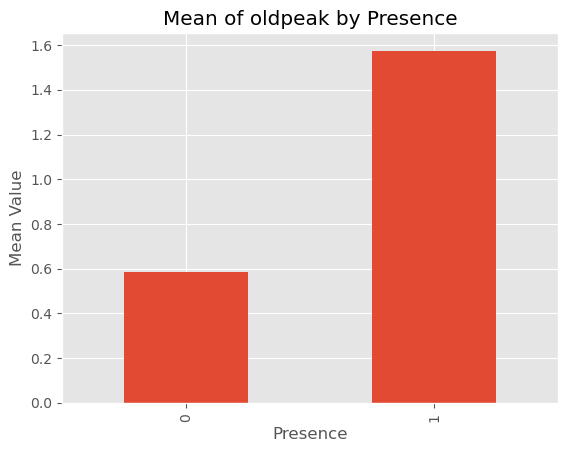

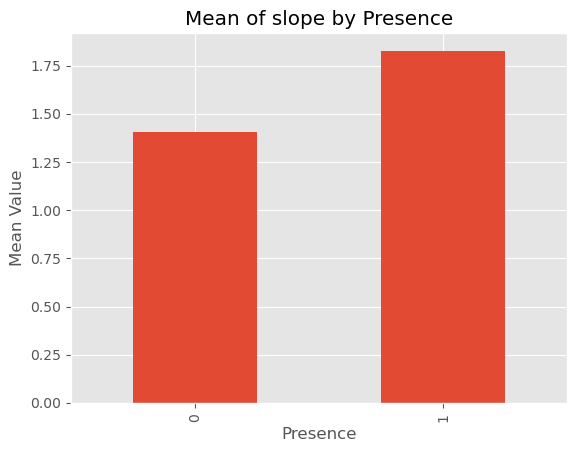

In [16]:
numerical_cols = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope"]

for col in numerical_cols:
    means = heart.groupby("present")[col].mean()
    plt.style.use("ggplot")
    means.plot(kind="bar")
    plt.title(f"Mean of {col} by Presence")
    plt.ylabel("Mean Value")
    plt.xlabel("Presence")
    plt.show()

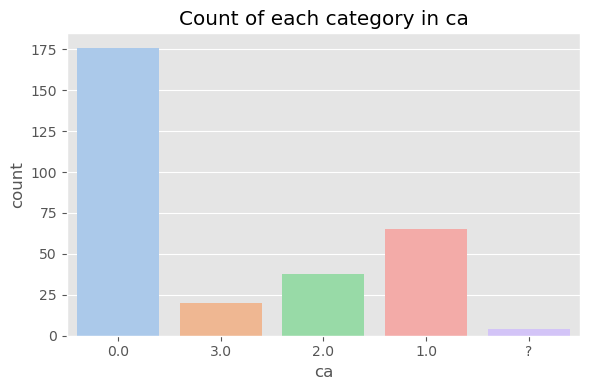

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(data=heart, x="ca", hue="ca", palette="pastel", legend=False)
plt.title(f"Count of each category in ca")
plt.tight_layout()
plt.show()

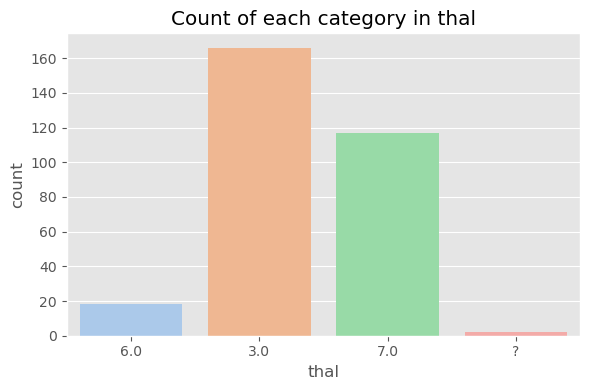

In [59]:
plt.figure(figsize=(6, 4))
sns.countplot(data=heart, x="thal", hue="thal", palette="pastel", legend=False)
plt.title(f"Count of each category in thal")
plt.tight_layout()
plt.show()

## Feature Selection

After initial exploration and stratifying the dataset by the target variable (`present`), several features showed a noticeable difference between classes. Based on both visual patterns and domain knowledge about heart disease, the following variables were identified as strong candidates for predictors:

- `age`: Age is a known risk factor for heart disease.
- `thalach`: Maximum heart rate achieved; lower values may indicate compromised heart function.
- `restecg`: Resting ECG results can reveal abnormalities in heart rhythm or structure.
- `ca`: The number of major vessels colored by fluoroscopy is directly related to heart health.

These features will be prioritized in model building due to their clinical relevance and statistical variation across outcome classes.


## Dividing the Data

To properly assess our logistic regression model, we divide the dataset into two parts:

- **Training set**: Used to fit the model and estimate coefficients.
- **Test set**: Used to evaluate the model’s predictive performance on unseen data.

We ensure that both the training and test sets are stratified, meaning they contain a similar proportion of positive (`present = 1`) and negative (`present = 0`) cases. This helps maintain a balanced class distribution during training and evaluation.


In [75]:
X = heart[["age", "thalach", "restecg", "ca"]]
y = heart["present"]

X = pd.get_dummies(X, columns=["ca"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [77]:
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

Train class distribution:
 present
0    0.53719
1    0.46281
Name: proportion, dtype: float64
Test class distribution:
 present
0    0.557377
1    0.442623
Name: proportion, dtype: float64


## Building the Model

With the data split, we now build a logistic regression model using our selected predictors. We'll start by evaluating its performance on the **training set**, focusing on key metrics:

- **Accuracy**: Overall correctness of the model.
- **Sensitivity** (True Positive Rate): How well the model identifies positive cases.
- **Specificity** (True Negative Rate): How well the model identifies negative cases.

In [111]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

train_predictions = model.predict(X_train_scaled)

In [113]:
report = classification_report(y_train, train_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       130
           1       0.76      0.69      0.72       112

    accuracy                           0.76       242
   macro avg       0.76      0.75      0.75       242
weighted avg       0.76      0.76      0.75       242



## Interpreting the Model Coefficients

Now that we've trained our logistic regression model, we examine the coefficients to understand how each predictor relates to heart disease.

In logistic regression, coefficients represent changes in **log-odds**. A positive coefficient indicates increased odds of heart disease with a higher predictor value, while a negative coefficient indicates decreased odds.

We typically interpret these in terms of **odds ratios** by exponentiating the coefficients:

**Odds Ratio = e^beta**


This helps us understand the practical impact of each variable. Let's explore what the coefficients for our predictors suggest.


In [104]:
feature_names = X_train.columns.tolist()

for name, coef in zip(feature_names, model.coef_[0]):
    print(f"{name}: {coef:.2f}")

age: -0.28
thalach: -0.89
restecg: 0.34
ca_1.0: 0.59
ca_2.0: 0.91
ca_3.0: 0.56
ca_?: 0.02


In [107]:
for name, val  in zip(feature_names, model.coef_[0]):
    print(name, ":", round(np.exp(val), 2))

age : 0.76
thalach : 0.41
restecg : 1.4
ca_1.0 : 1.81
ca_2.0 : 2.49
ca_3.0 : 1.75
ca_? : 1.02


Here's what our model coefficients and corresponding odds ratios suggest:

- **age**: Coefficient = -0.28 → Odds Ratio = **0.76**  
  → Each additional year of age is associated with a **24% decrease** in the odds of heart disease.

- **thalach** (maximum heart rate): Coefficient = -0.89 → Odds Ratio = **0.41**  
  → Higher heart rate is linked to **59% lower** odds of heart disease.

- **restecg** (ECG results): Coefficient = 0.34 → Odds Ratio = **1.40**  
  → Abnormal ECG results are associated with a **40% increase** in the odds of heart disease.

- **ca_1.0**: Coefficient = 0.59 → Odds Ratio = **1.81**  
- **ca_2.0**: Coefficient = 0.91 → Odds Ratio = **2.49**  
- **ca_3.0**: Coefficient = 0.56 → Odds Ratio = **1.75**  
  → More vessels colored by fluoroscopy is strongly linked with increased heart disease risk.

- **ca_?**: Coefficient = 0.02 → Odds Ratio = **1.02**  
  → Unknown/missing values in this feature have minimal effect on prediction.

These insights help validate the model’s behavior and align reasonably with medical understanding.

In [115]:
test_predictions = model.predict(X_test_scaled)

test_report = classification_report(y_test, test_predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        34
           1       0.77      0.74      0.75        27

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



## Conclusion

The logistic regression model achieved an **accuracy of 79%** on the test dataset, with balanced performance across both classes:

- **Precision**: 80% for non-cases (0), 77% for cases (1)  
- **Recall**: 82% for non-cases, 74% for cases  
- **F1-Score**: 81% for non-cases, 75% for cases  

These results indicate that the model performs reasonably well in identifying both patients with and without heart disease, though it is slightly better at detecting non-cases. Overall, the model generalizes well and provides a solid baseline for further refinement or comparison with more complex classifiers.
